In [7]:
# reporting/quarterly_report/modules/granting.py
from __future__ import annotations

import logging, sqlite3, datetime
from pathlib import Path
from typing import List
import calendar
import pandas as pd
from datetime import date
from typing import List, Tuple,Union
import numpy as np
from great_tables import GT, loc, style, html

# our project
from ingestion.db_utils import (
    init_db,                                 # create tables if missing
    fetch_latest_table_data,                 # new version!
    get_alias_last_load,
    get_variable_status, 
    load_report_params                   # to inspect results
)

from reporting.quarterly_report.utils import RenderContext, BaseModule
from reporting.quarterly_report.report_utils.granting_utils import enrich_grants, _ensure_timedelta_cols, _coerce_date_columns
from reporting.quarterly_report.utils import Database, RenderContext


import altair as alt
from altair_saver import save
import selenium.webdriver



# ─────────────────────────────────────────────────────────────
# 2) open DB – change path if you work on a copy
# ─────────────────────────────────────────────────────────────
db_path = "database/reporting.db"
DB_PATH = Path("database/reporting.db")

init_db(db_path=DB_PATH)            # no-op if tables already exist

db = Database(str(DB_PATH))         # thin sqlite3 wrapper
conn = db.conn
report = 'Quarterly_Report'

# ──────────────────────────────────────────────────────────────
# constants – adapt whenever a file-alias changes
# ──────────────────────────────────────────────────────────────

AMENDMENT_ALIAS = "amendments"
cutoff = pd.to_datetime("2025-04-15")

CALLS_TYPES_LIST = ['STG', 'ADG', 'POC', 'COG', 'SYG', 'StG', 'CoG', 'AdG', 'SyG', 'PoC', 'CSA']
# ──────────────────────────────────────────────────────────────
# HELPERS
# ──────────────────────────────────────────────────────────────

def determine_epoch_year(cutoff_date: pd.Timestamp) -> int:
    """
    Returns the correct reporting year.
    If the cutoff is in January, then we are reporting for the *previous* year.
    """
    return cutoff_date.year - 1 if cutoff_date.month == 1 else cutoff_date.year



def get_scope_start_end(cutoff: pd.Timestamp, amendments_report_date: pd.Timestamp) -> Tuple[pd.Timestamp, pd.Timestamp]:
    """
    Unified scope logic with year transition:
    • If cutoff is in January → report full previous year
    • Otherwise → return start of year to quarter-end
    """
    if cutoff.month == 1:
        year = cutoff.year - 1
        return pd.Timestamp(year=year, month=1, day=1), pd.Timestamp(year=year, month=12, day=31)

    def quarter_end(cutoff: pd.Timestamp) -> pd.Timestamp:
        first_day = cutoff.replace(day=1)
        last_month = first_day - pd.offsets.MonthBegin()
        m = last_month.month

        if m <= 3:
            return pd.Timestamp(year=cutoff.year, month=3, day=31)
        elif m <= 6:
            return pd.Timestamp(year=cutoff.year, month=6, day=30)
        elif m <= 9:
            return pd.Timestamp(year=cutoff.year, month=9, day=30)
        else:
            return pd.Timestamp(year=cutoff.year, month=12, day=31)

    return pd.Timestamp(year=cutoff.year, month=1, day=1), quarter_end(cutoff)



def months_in_scope(cutoff: pd.Timestamp) -> list[str]:
    """
    Returns list of month names from January to last *full* month before cutoff.
    Handles year rollover if cutoff is in January.
    """
    if cutoff.month == 1:
        year = cutoff.year - 1
        end_month = 12
    else:
        year = cutoff.year
        end_month = cutoff.month - 1

    months = pd.date_range(
        start=pd.Timestamp(year=year, month=1, day=1),
        end=pd.Timestamp(year=year, month=end_month, day=1),
        freq="MS"
    ).strftime("%B").tolist()

    return months

# Function to determine PO_CATEGORY based on the rules
def determine_po_category(row):
    instrument = str(row.get('INSTRUMENT', '')).strip()
    topic = str(row.get( 'TOPIC', '')).strip()

    # Check PO ABAC SAP Reference first
    if topic and any(call_type in topic for call_type in CALLS_TYPES_LIST):
            return next(call_type for call_type in CALLS_TYPES_LIST if call_type in topic).upper()
    # If empty or no match, check PO Purchase Order Desc
    elif instrument and any(call_type in instrument for call_type in CALLS_TYPES_LIST):
        return next(call_type for call_type in CALLS_TYPES_LIST if call_type in instrument).upper()
    return ''  # Default value for other cases

## function for detecting nan cells
def is_nan(x):
    return (x != x)

def update_start_date(row, amd_report_date):
    status = row['STATUS']
    tta_ongoing = row['TTA\nONGOING']
    tta = row['TTA']
    
    # Coerce to datetime
    end_date = pd.to_datetime(row['END\nDATE'], errors='coerce')
    start_date = pd.to_datetime(row['START\nDATE'], errors='coerce')
    amd_report_date = pd.to_datetime(amd_report_date, errors='coerce')
    
    if status in ['SIGNED_CR', 'REJECTED_CR', 'WITHDRAWN_CR']:
        delta = pd.to_timedelta(tta, unit='D') if not pd.isna(tta) else pd.to_timedelta(tta_ongoing, unit='D')
        if pd.isna(delta):
            return row
        row['START\nDATE'] = end_date - delta if not pd.isna(end_date) else amd_report_date - delta
    
    elif status in ['RECEIVED_CR', 'ASSESSED_CR', 'MISSING_INFO', 'OPENED_EXT_CR', 'OPENED_INT_CR']:
        if not pd.isna(tta_ongoing):
            delta = pd.to_timedelta(tta_ongoing, unit='D')
            row['START\nDATE'] = amd_report_date - delta

    return row





In [1]:

# reporting/quarterly_report/modules/granting.py
from __future__ import annotations

from reporting.quarterly_report.report_utils.amendments_tc_builder import determine_epoch_year, get_scope_start_end, months_in_scope, is_nan, update_start_date, determine_po_category, chart_machine_tta, amendment_cases, generate_amendment_pivot, rolling_tta, table_signed_function
import logging, sqlite3, datetime
from pathlib import Path
from typing import List
import calendar
import pandas as pd
from datetime import date
from typing import List, Tuple,Union
import numpy as np
from great_tables import GT, loc, style, html

# our project
from ingestion.db_utils import (
    init_db,                                 # create tables if missing
    fetch_latest_table_data,                 # new version!
    get_alias_last_load,
    get_variable_status, 
    load_report_params                   # to inspect results
)

from reporting.quarterly_report.utils import RenderContext, BaseModule
from reporting.quarterly_report.report_utils.granting_utils import enrich_grants, _ensure_timedelta_cols, _coerce_date_columns
from reporting.quarterly_report.utils import Database, RenderContext


import altair as alt
from altair_saver import save
import selenium.webdriver

# ─────────────────────────────────────────────────────────────
# 2) open DB – change path if you work on a copy
# ─────────────────────────────────────────────────────────────
db_path = "database/reporting.db"
DB_PATH = Path("database/reporting.db")

init_db(db_path=DB_PATH)            # no-op if tables already exist

db = Database(str(DB_PATH))         # thin sqlite3 wrapper
conn = db.conn
report = 'Quarterly_Report'

# ──────────────────────────────────────────────────────────────
# constants – adapt whenever a file-alias changes
# ──────────────────────────────────────────────────────────────

AMENDMENT_ALIAS = "amendments"
cutoff = pd.to_datetime("2025-04-15")

CALLS_TYPES_LIST = ['STG', 'ADG', 'POC', 'COG', 'SYG', 'StG', 'CoG', 'AdG', 'SyG', 'PoC', 'CSA']
# ───────────────────────────────────────

f:\vinci\Projects\QuarterlyReport\reporting\quarterly_report\modules\granting.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  MONTHS_ORDER = list(pd.date_range("2000-01-01", periods=12, freq="M").strftime("%B"))


In [2]:
# ──────────────────────────────────────────────────────────────
# REPORT KIK-OFF
# ──────────────────────────────────────────────────────────────

report_params = load_report_params(report_name=report, db_path=db_path)
amd_report_date = report_params.get("amendments_report_date")
table_colors = report_params.get('TABLE_COLORS')

# Define colors if table_colors is not provided
BLUE = table_colors.get("BLUE", "#004A99") if table_colors else "#004A99"
LIGHT_BLUE = table_colors.get("LIGHT_BLUE", "#d6e6f4") if table_colors else "#d6e6f4"
# GRID_CLR = table_colors.get("GRID_CLR", "#004A99") if table_colors else "#004A99"
DARK_BLUE = table_colors.get("DARK_BLUE", "#01244B") if table_colors else "#01244B"
SUB_TOTAL_BACKGROUND = table_colors.get("subtotal_background_color", "#E6E6FA") if table_colors else "#E6E6FA"

#only for testing#
amd_report_date = pd.to_datetime("2025-01-15")

df = fetch_latest_table_data(conn , AMENDMENT_ALIAS, cutoff)

epoch_year = determine_epoch_year(cutoff)
year_start, year_end = get_scope_start_end(cutoff, amd_report_date)
month_names = months_in_scope(cutoff)


CALLS_TYPES_LIST = ['STG','ADG','POC','COG','SYG','StG','CoG','AdG','SyG', 'PoC', 'CSA']

# Ensure df_summa_filtered is a new DataFrame to avoid SettingWithCopyWarning
df_amd = df.copy()

# Apply the function to create the new column using .loc
df_amd.loc[:, 'CALL_TYPE'] = df_amd.apply(determine_po_category, axis=1)
df_amd = df_amd[df_amd['CALL_TYPE'] != 'CSA'].copy()
df_amd = df_amd[df_amd['AMENDMENT\nTYPE'] == 'CONSORTIUM_REQUESTED'].copy()

###### LOGIC FOR START DATE COMPUTATION #############################
df_amd = df_amd.apply(lambda row: update_start_date(row, amd_report_date), axis=1)

# Only explode 'DESCRIPTION' safely
df_amd_cases = df_amd.copy()
df_amd_cases['DESCRIPTION'] = df_amd_cases['DESCRIPTION'].astype(str).str.split('\n')
df_amd_cases = df_amd_cases.explode('DESCRIPTION')

# Drop empty or NaN values
df_amd_cases['DESCRIPTION'] = (
    df_amd_cases['DESCRIPTION']
    .astype(str)
    .str.strip()
    .str.replace(r'_x000D_', '', regex=True)
    .str.lstrip('+-')
)

df_amd_cases['DESCRIPTION'] = df_amd_cases['DESCRIPTION'].replace("", np.nan)
df_amd_cases.dropna(subset=['DESCRIPTION'], inplace=True)

# Add counter for pivoting later
df_amd_cases['COUNTER'] = 1

# Ensure date column is parsed
df_amd_cases['START\nDATE'] = pd.to_datetime(df_amd_cases['START\nDATE'], errors='coerce')

# Filter by reporting year
df_amd_cases = df_amd_cases[df_amd_cases['START\nDATE'] > year_start].copy()

df_amd['START\nDATE'] = pd.to_datetime(df_amd['START\nDATE'], errors='coerce')
df_amd['END\nDATE'] = pd.to_datetime(df_amd['END\nDATE'], errors='coerce')

df_amd['StartYear'] = df_amd['START\nDATE'].dt.year
df_amd['StartMonth'] = df_amd['START\nDATE'].dt.month
df_amd['EndYear'] = df_amd['END\nDATE'].dt.year
df_amd['EndMonth'] = df_amd['END\nDATE'].dt.month


# Add necessary time columns for filtering
df_amd_cases['StartYear'] = pd.DatetimeIndex(df_amd_cases['START\nDATE']).year
df_amd_cases['StartMonth'] = pd.DatetimeIndex(df_amd_cases['START\nDATE']).month



DEBUG:root:Fetching latest data for table_alias: amendments, cutoff: 2025-04-15T00:00:00
DEBUG:root:Upload log query results for amendments: [('2025-05-21T15:42:58.230629', 12)]
DEBUG:root:Checking upload_id: 12, uploaded_at: 2025-05-21T15:42:58.230629
DEBUG:root:Fetched 18985 rows from amendments with upload_id 12
DEBUG:Amendments:Determining epoch year for cutoff_date: 2025-04-15 00:00:00
DEBUG:Amendments:Calculating scope for cutoff: 2025-04-15 00:00:00, amendments_report_date: 2025-01-15 00:00:00
DEBUG:Amendments:Scope start: 2025-01-01 00:00:00, end: 2025-03-31 00:00:00
DEBUG:Amendments:Determining months in scope for cutoff: 2025-04-15 00:00:00
DEBUG:Amendments:Months in scope: ['January', 'February', 'March']


In [ ]:
df_amd.to_excel('amd.xlsx', index=False)

In [ ]:
df_amd_cases.head(2)

In [ ]:
# ──────────────────────────────────────────────────────────────
# TABLES FUNCTIONS
# ──────────────────────────────────────────────────────────────

def amendment_cases(
    df_amd_cases: pd.DataFrame,
    programme: str,
    months_scope: list[int],
    epoch_year: int
) -> pd.DataFrame:
    df = df_amd_cases.copy()

    # Normalize
    # df['INSTRUMENT'] = df['INSTRUMENT'].apply(lambda x: 'ERC-POC' if 'POC' in str(x) else x)

    # Filter by programme and time scope
    df = df[
        (df['FRAMEWORK'] == programme) &
        (df['StartYear'] == epoch_year) &
        (df['StartMonth'].isin(months_scope))
    ]

    # Pivot
    pivot = df.pivot_table(
        index='DESCRIPTION',
        columns='CALL_TYPE',
        values='COUNTER',
        fill_value=0,
        aggfunc='sum'
    ).reset_index()

    # Compute %s
    instrument_cols = [col for col in pivot.columns if col != 'DESCRIPTION']
    for col in instrument_cols:
        pct_col = f'As % of Total {col}'
        pivot[pct_col] = pivot[col] / pivot[col].sum()

    new_cols = []
    for col in instrument_cols:
        pct_col = f'As % of Total {col}'
        new_cols.extend([col, pct_col])
    pivot = pivot[['DESCRIPTION'] + new_cols]

    # Total row
    totals = pivot[instrument_cols].sum()
    totals['DESCRIPTION'] = 'Total'
    for col in instrument_cols:
        totals[f'As % of Total {col}'] = 1.0
    pivot = pd.concat([pivot, pd.DataFrame([totals])], ignore_index=True)

    # Final total col
    pivot['Total No'] = pivot[instrument_cols].sum(axis=1)
    total_of_totals = pivot.loc[pivot['DESCRIPTION'] == 'Total', 'Total No'].values[0]
    pivot['Total No Pct'] = pivot['Total No'] / total_of_totals

    # Format %
    for col in pivot.columns:
        if 'As % of Total' in col or col == 'Total No Pct':
            pivot[col] = pivot[col].map('{:.1%}'.format)

    return pivot



def generate_amendment_pivot(
    df: pd.DataFrame,
    programme: str,
    statuses: List[str],
    value_col: str,
    aggfunc: Union[str, callable],
    column_name: str,
    months_scope: List[int],
    epoch_year: int,
    month_col: str = 'EndMonth',
    year_col: str = 'EndYear',
    fill_value=0,
    margin_name='Total',
    rename_col='Month'
) -> pd.DataFrame:
    """
    Generate a pivot table for amendment counts or averages over months.

    Parameters:
    - df: Source DataFrame.
    - programme: Filter by framework.
    - statuses: List of statuses to include (e.g., ['SIGNED_CR']).
    - value_col: Column to aggregate (e.g., 'Counter' or 'TTA').
    - aggfunc: Aggregation method (np.sum, np.mean, or string equivalents).
    - column_name: Label used in output context.
    - months_scope: List of month integers to include.
    - epoch_year: Year to filter by in 'EndYear' or 'StartYear'.
    - month_col: Column with month numbers (default 'EndMonth').
    - year_col: Column with year values (default 'EndYear').
    - fill_value: Fill missing values (default 0).
    - margin_name: Label for totals row (default 'Total').
    - rename_col: Column name to show month names (default 'Month').

    Returns:
    - A formatted pivot DataFrame.
    """
    df = df.copy()
    # df['INSTRUMENT'] = df['INSTRUMENT'].apply(lambda x: 'ERC-POC' if 'POC' in str(x) else x)

    # Normalize aggregation function
    if isinstance(aggfunc, str):
        aggfunc_str = aggfunc
    elif aggfunc == np.sum:
        aggfunc_str = 'sum'
    elif aggfunc == np.mean:
        aggfunc_str = 'mean'
    else:
        aggfunc_str = aggfunc  # leave as-is for custom functions

    # Filter data
    df_filtered = df[
        (df['FRAMEWORK'] == programme) &
        (df[year_col] == epoch_year) &
        (df['STATUS'].isin(statuses)) &
        (df[month_col].isin(months_scope))
    ].copy()

    df_filtered['Counter'] = 1  # Used if value_col == 'Counter'

    # Generate pivot
    pivot = df_filtered.pivot_table(
        index=[month_col],
        columns='CALL_TYPE',
        values=value_col,
        fill_value=fill_value,
        aggfunc=aggfunc_str,
        margins=True,
        margins_name=margin_name
    )

    pivot.reset_index(inplace=True)

    # Drop MultiIndex if needed
    if isinstance(pivot.columns, pd.MultiIndex):
        pivot.columns = pivot.columns.droplevel()

    # Rename month column
    pivot.rename(columns={pivot.columns[0]: rename_col}, inplace=True)

    # Fill missing months
    existing_months = pivot[rename_col].tolist()
    missing_months = [m for m in months_scope if m not in existing_months]

    if missing_months:
        for m in missing_months:
            pivot = pd.concat([pivot, pd.DataFrame([{rename_col: m}])], ignore_index=True)

        not_total = pivot[pivot[rename_col] != margin_name]
        total_row = pivot[pivot[rename_col] == margin_name]
        pivot = pd.concat([not_total.sort_values(by=rename_col), total_row], ignore_index=True)

    # Replace month numbers with abbreviated month names
    month_map = {i: calendar.month_abbr[i] for i in range(1, 13)}
    pivot[rename_col] = pivot[rename_col].map(month_map).fillna(pivot[rename_col])

    return pivot.fillna(0)



def rolling_tta(df: pd.DataFrame, programme: str, months_scope: list[int]) -> pd.DataFrame:
    df_filtered = df[
        (df['FRAMEWORK'] == programme) &
        (df['EndYear'] == epoch_year) &
        (df['STATUS'] == 'SIGNED_CR') &
        (~df['TTA'].isna())
        ]

    results = []
    for month in months_scope:
        df_subset = df_filtered[df_filtered['EndMonth'] <= month]
        mean_val = df_subset['TTA'].mean()
        results.append({'Month': month, 'TTA': mean_val})

    return pd.DataFrame(results)

def table_signed_function(
    df: pd.DataFrame,
    programme: str,
    months_scope: list[int],
    epoch_year: int
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generate signed amendment count and average TTA pivot tables.

    Returns:
        - Count pivot table
        - TTA average pivot table
    """
    # Normalize instrument names
    df = df.copy()
    df['INSTRUMENT'] = df['INSTRUMENT'].apply(lambda x: 'ERC-POC' if 'POC' in str(x) else x)

    # Filter signed records with TTA info
    signed_mask = (
        (df['FRAMEWORK'] == programme) &
        (df['EndYear'] == epoch_year) &
        (df['STATUS'] == 'SIGNED_CR') &
        (~df['TTA'].isna() | ~df['TTA\nONGOING'].isna())
    )
    df_signed = df[signed_mask].copy()

    # Count pivot
    pivot_signed = generate_amendment_pivot(
        df_signed,
        programme=programme,
        statuses=['SIGNED_CR'],
        value_col='Counter',
        aggfunc=np.sum,
        column_name='Signed',
        months_scope=months_scope,
        epoch_year=epoch_year,
        month_col='EndMonth',
        year_col='EndYear'
    )

    # TTA average pivot
    pivot_tta = generate_amendment_pivot(
        df_signed,
        programme=programme,
        statuses=['SIGNED_CR'],
        value_col='TTA',
        aggfunc=np.mean,
        column_name='TTA Average',
        months_scope=months_scope,
        epoch_year=epoch_year,
        month_col='EndMonth',
        year_col='EndYear'
    ).round(1)

    return pivot_signed, pivot_tta



In [3]:
import pandas as pd
import altair as alt
from datetime import date
import calendar
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def chart_machine_tta(df: pd.DataFrame, prog: str, rolling_tta: pd.DataFrame) -> alt.Chart:
    """
    Render TTA performance chart with monthly values, rolling averages,
    contractual time limits, and annotation.
    """
    colorScheme = "blues"
    title_color = '#1B5390'

    def my_theme():
                    return {
                    'config': {
                        'view': {'continuousHeight': 300, 'continuousWidth': 400},  # from the default theme
                        'range': {'category': {'scheme': colorScheme }},
                        "title": {"fontSize": 18, "font": 'Lato', "anchor": "center",'color':title_color,'fontWeight':'bold',},
                        "legend" :{'labelColor':'black',"strokeColor":"black","padding": 10,"strokeColor": '#49b2d0','fillColor':'#d6eef4'}
                    }
                    }
    alt.themes.register('my_theme', my_theme)
    alt.themes.enable('my_theme')

    # Convert month names to numbers (safe mapping for altair x-axis)
    month_abbr_map = {abbr: i for i, abbr in enumerate(calendar.month_abbr) if abbr}
    df = df.copy()
    df = df[df['Month'] != 'Total']  # Drop total row if present
    df['MonthNum'] = df['Month'].map(month_abbr_map)
    df['TTA'] = df['Total']  # assume Total col is the TTA to plot per month

    # Time limit line (static for 12 months)
    df_time_limit = pd.DataFrame({
        'MonthNum': list(range(1, 13)),
        'time_limit': [45] * 12
    })

    # Clean rolling_tta input
    rolling_tta = rolling_tta.dropna(subset=['TTA']).copy()
    rolling_tta['MonthNum'] = rolling_tta['Month'].astype(int)
    rolling_tta['TTA'] = pd.to_numeric(rolling_tta['TTA'], errors='coerce')

    # TTA bars
    bar = alt.Chart(df).mark_bar(
        size=45,
        opacity=0.7,
        color='#4c78a8'
    ).encode(
        x=alt.X('MonthNum:O', title='Month', axis=alt.Axis(labelExpr='datum.label', labelAngle=0)),
        y=alt.Y('TTA:Q', title='Number of Days'),
    )

    # Labels
    labels = alt.Chart(df).mark_text(
        dy=-10,
        color='black',
        fontSize=12,
        fontWeight='bold'
    ).encode(
        x='MonthNum:O',
        y='TTA:Q',
        text=alt.Text('TTA:Q', format='.1f')
    )

    # Rolling average line
    avg_line = alt.Chart(rolling_tta).mark_line(
        strokeDash=[4, 3],
        color='red',
        size=2
    ).encode(
        x='MonthNum:O',
        y='TTA:Q'
    )

    # Time limit line
    limit_line = alt.Chart(df_time_limit).mark_line(
        color='orange',
        size=2
    ).encode(
        x='MonthNum:O',
        y='time_limit:Q'
    )

    # Optional annotation (only if data exists)
    if not rolling_tta.empty:
        last_row = rolling_tta.iloc[-1]
        annotation_df = pd.DataFrame([{
            'MonthNum': last_row['MonthNum'],
            'TTA': last_row['TTA'],
            'Comment': f'{prog} Avg TTA {date.today().year}: {last_row["TTA"]:.1f}',
            'Arrow': '➟'
        }])

        annotation_text = alt.Chart(annotation_df).mark_text(
            dx=-50, dy=-50, fontSize=13, fontWeight='bold', color='black'
        ).encode(
            x='MonthNum:O',
            y='TTA:Q',
            text='Comment'
        )

        arrow = alt.Chart(annotation_df).mark_text(
            dx=-30, dy=-5, angle=90, fontSize=26, color='orange'
        ).encode(
            x='MonthNum:O',
            y='TTA:Q',
            text='Arrow'
        )

        chart = (bar + labels + avg_line + limit_line + annotation_text + arrow)
    else:
        chart = (bar + labels + limit_line)

    return chart.properties(title=f'{prog} Quarterly - TTA ', width=600, height=300)



In [6]:
# ──────────────────────────────────────────────────────────────
# TABLES FUNCTIONS RUN 
# ──────────────────────────────────────────────────────────────

# Months in scope
months_scope = list(range(1, len(month_names) + 1))

month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
             7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

# Signed amendments count
amd_H2020_signed = generate_amendment_pivot(df_amd, 'H2020', ['SIGNED_CR'], 'Counter', 'sum', 'Signed', months_scope, epoch_year)
amd_He_signed = generate_amendment_pivot(df_amd, 'HORIZON', ['SIGNED_CR'], 'Counter', 'sum', 'Signed', months_scope,  epoch_year)
# Rejected amendments count
amd_H2020_rejected = generate_amendment_pivot(df_amd, 'H2020', ['REJECTED_CR', 'WITHDRAWN_CR'], 'Counter', np.sum, 'Rejected', months_scope,  epoch_year)
amd_He_rejected = generate_amendment_pivot(df_amd, 'HORIZON', ['REJECTED_CR', 'WITHDRAWN_CR'], 'Counter', np.sum, 'Rejected', months_scope,  epoch_year)
# Received amendments count (complex status list)
received_statuses = [
    'SIGNED_CR', 'ASSESSED_CR', 'OPENED_EXT_CR', 'OPENED_INT_CR', 'RECEIVED_CR', 'WITHDRAWN_CR', 'REJECTED_CR'
]
amd_H2020_received  = generate_amendment_pivot(df_amd, 'H2020', received_statuses, 'Counter', np.sum, 'Received', months_scope,  epoch_year, month_col='StartMonth', year_col='StartYear')
amd_He_received  = generate_amendment_pivot(df_amd, 'HORIZON', received_statuses, 'Counter', np.sum, 'Received', months_scope,  epoch_year,  month_col='StartMonth', year_col='StartYear')


amd_H2020_received['TYPE_ROW_NAME'] = 'Amendments Received'
amd_H2020_signed['TYPE_ROW_NAME'] = 'Amendments Signed'
amd_H2020_rejected['TYPE_ROW_NAME'] = 'Amendments Rejected or Withdrawn'

amd_H2020_overview = pd.concat([amd_H2020_received, amd_H2020_signed, amd_H2020_rejected])

amd_He_received['TYPE_ROW_NAME'] = 'Amendments Received'
amd_He_signed['TYPE_ROW_NAME'] = 'Amendments Signed'
amd_He_rejected['TYPE_ROW_NAME'] = 'Amendments Rejected or Withdrawn'

amd_He_overview = pd.concat([amd_He_received,amd_He_signed,amd_He_rejected])

amd_cases_table_h2020 = amendment_cases(
    df_amd_cases,
    programme='H2020',
    months_scope= months_scope,
    epoch_year = epoch_year
)

amd_cases_table_he = amendment_cases(
    df_amd_cases,
    programme='HORIZON',
    months_scope= months_scope,
    epoch_year = epoch_year
)

try:
    rolling_tta_H2020 = rolling_tta(df_amd , 'H2020', months_scope)
except:
    pass

try:
    rolling_tta_H2020 = rolling_tta(df_amd , 'H2020', months_scope, epoch_year)
except:
    pass

rolling_tta_H2020 = rolling_tta_H2020.dropna(subset=['Month', 'TTA']).copy()
rolling_tta_H2020 ['Month'] = rolling_tta_H2020 ['Month'].astype(int)
rolling_tta_H2020 ['TTA'] = pd.to_numeric(rolling_tta_H2020['TTA'], errors='coerce')




try:
    rolling_tta_HEU = rolling_tta(df_amd, 'HORIZON', months_scope)
except:
    pass

try:
    rolling_tta_HEU = rolling_tta(df_amd, 'HORIZON', months_scope, epoch_year)
except:
    pass
rolling_tta_HEU = rolling_tta_HEU.dropna(subset=['Month', 'TTA']).copy()
rolling_tta_HEU ['Month'] = rolling_tta_HEU ['Month'].astype(int)
rolling_tta_HEU ['TTA'] = pd.to_numeric(rolling_tta_HEU ['TTA'], errors='coerce')


pivot_signed_h2020, pivot_tta_h2020 = table_signed_function(
    df_amd,
    programme='H2020',
    months_scope=months_scope,
    epoch_year=epoch_year
)

pivot_signed_he, pivot_tta_he = table_signed_function(
    df_amd,
    programme='HEU',
    months_scope=months_scope,
    epoch_year=epoch_year
 )


INFO:Amendments:Starting generate_amendment_pivot for programme: H2020, statuses: ['SIGNED_CR'], value_col: Counter
DEBUG:Amendments:Input DataFrame shape: (13164, 29), columns: ['PROJECT\nNUMBER', 'ACRONYM', 'UNIT', 'FRAMEWORK', 'CALL', 'INSTRUMENT', 'TOPIC', 'PO Name', 'LO Name', 'FO Name', 'AMENDMENT\nREFERENCE', 'AMENDMENT\nNUMBER', 'AMENDMENT\nVERSION', 'AMENDMENT\nTYPE', 'TTA', 'TTA\nONGOING', 'START\nDATE', 'END\nDATE', 'STATUS', 'SIGNED BY BOTH PARTIES', 'DESCRIPTION', 'CURRENT TASK', 'upload_id', 'uploaded_at', 'CALL_TYPE', 'StartYear', 'StartMonth', 'EndYear', 'EndMonth']
DEBUG:Amendments:Copied input DataFrame
DEBUG:Amendments:Aggregation function: sum
DEBUG:Amendments:Filtered DataFrame shape: (211, 29)
DEBUG:Amendments:Added Counter column
DEBUG:Amendments:Pivot table created, shape: (4, 5), columns: ['ADG', 'COG', 'STG', 'SYG', 'Total']
DEBUG:Amendments:Reset index
DEBUG:Amendments:Renamed first column to: Month
DEBUG:Amendments:Existing months: [1.0, 2.0, 3.0, 'Total'], 

In [7]:
amd_cases_table_he

CALL_TYPE,DESCRIPTION,ADG,As % of Total ADG,COG,As % of Total COG,POC,As % of Total POC,STG,As % of Total STG,SYG,As % of Total SYG,Total No,Total No Pct
0,Addition of a new beneficiary,8,12.1%,14,11.2%,3,5.7%,26,10.1%,3,12.0%,54,10.2%
1,Addition of an affiliated entity,2,3.0%,1,0.8%,0,0.0%,1,0.4%,1,4.0%,5,0.9%
2,Beneficiary termination,2,3.0%,8,6.4%,2,3.8%,16,6.2%,0,0.0%,28,5.3%
3,Change concerning listed equipment,0,0.0%,0,0.0%,0,0.0%,0,0.0%,1,4.0%,1,0.2%
4,Change of Annex 1,15,22.7%,24,19.2%,12,22.6%,46,17.8%,8,32.0%,105,19.9%
5,Change of Annex 2,11,16.7%,19,15.2%,4,7.5%,33,12.8%,5,20.0%,72,13.7%
6,Change of associated partner link,0,0.0%,0,0.0%,1,1.9%,0,0.0%,0,0.0%,1,0.2%
7,Change of legal status,9,13.6%,13,10.4%,3,5.7%,20,7.8%,5,20.0%,50,9.5%
8,Change of non-contractual information,2,3.0%,10,8.0%,2,3.8%,16,6.2%,1,4.0%,31,5.9%
9,Change of the bank account for payments,5,7.6%,12,9.6%,4,7.5%,34,13.2%,0,0.0%,55,10.4%


In [ ]:
total_rows_indices = amd_H2020_overview.reset_index().query('Month == "Total"').index.tolist()
outline_b = '2px'

tbl_H2020_overview = (
    GT(
        amd_H2020_overview,
        rowname_col="Month",
        groupname_col="TYPE_ROW_NAME"
    )
    .tab_header(title="H2020")
    
    .opt_table_font(font="Arial")
    .opt_table_outline(style = "solid", width = outline_b, color =  DARK_BLUE) 
    # Header style
    .tab_style(
        style.text(color=DARK_BLUE, weight="bold", align="center", font='Arial'),
        locations=loc.header()
    )
    
    .tab_stubhead(label="Month")

    # Row group styling
    .tab_style(
        style=[
            style.text(color=DARK_BLUE, weight="bold", font='Arial', size='small'),
            style.fill(color=LIGHT_BLUE),
            style.css(f"border: 1px solid {DARK_BLUE}; line-height:1.2; padding:5px;")
        ],
        locations=loc.row_groups()
    )

    # Column labels styling
    .tab_style(
        style=[
            style.fill(color=BLUE),
            style.text(color="white", weight="bold", align="center", size='small'),
            style.css("min-width:60px; padding:5px; line-height:1.2")
           
        ],
        locations=loc.column_labels()
    )

    # Stubhead styling
    .tab_style(
        style=[
            style.fill(color=BLUE),
            style.text(color="white", weight="bold", align="center", size='small'),
            style.css("padding:5px; line-height:1.2")
        ],
        locations=loc.stubhead()
    )

    # Body cell styling
    .tab_style(
        style=[
            style.borders(sides="all", color=DARK_BLUE, weight="1px"),
            style.text(align="center", size='small', font='Arial'),
            style.css("padding:5px")
        ],
        locations=loc.body()
    )

    # Stub cell styling
    .tab_style(
        style=[
            style.borders(sides="all", color=DARK_BLUE, weight="1px"),
            style.text(size='small', font='Arial'),
            style.css("padding:5px")
        ],
        locations=loc.stub()
    )

    # Consistent and strong external border
    .tab_options(
        table_body_border_bottom_color=DARK_BLUE,
        table_body_border_bottom_width="1px",
        table_border_right_color=DARK_BLUE,
        table_border_right_width="1px",
        table_border_left_color=DARK_BLUE,
        table_border_left_width="1px",
        table_border_top_color=DARK_BLUE,
        table_border_top_width="1px",
        column_labels_border_top_color=DARK_BLUE,
        column_labels_border_top_width="1px"
    )

  
    # Format all "Total" rows consistently in stub and body
    .tab_style(
        style=[
            style.fill(color=SUB_TOTAL_BACKGROUND),
            style.text(color="black", weight="bold", font='Arial'),
        ],
        locations=[
            loc.body(rows=total_rows_indices ),
            loc.stub(rows=total_rows_indices )
        ]
    )

    # Footer styling
    .tab_source_note("Source: Compass")
    .tab_source_note("Report: Amendments Report")
    .tab_style(
        style=[
            style.text(size="small", font='Arial'),
            style.css("padding:5px; line-height:1.2")
        ],
        locations=loc.footer()
    )
)

tbl_H2020_overview


In [ ]:
amd_cases_table_h2020

In [ ]:
total_rows_indices = amd_cases_table_h2020.reset_index().query('DESCRIPTION == "Total"').index.tolist()
outline_b = '2px'

tbl_amd_cases_h2020 = (
    GT(
        amd_cases_table_h2020,
    )
    .tab_header(title="H2020")
    
    .opt_table_font(font="Arial")
    .opt_table_outline(style = "solid", width = outline_b, color =  DARK_BLUE) 
    # Header style
    .tab_style(
        style.text(color=DARK_BLUE, weight="bold", align="center", font='Arial'),
        locations=loc.header()
    )
    
    .tab_stubhead(label="Amd Description")

    # Row group styling
    .tab_style(
        style=[
            style.text(color=DARK_BLUE, weight="bold", font='Arial', size='small'),
            style.fill(color=LIGHT_BLUE),
            style.css(f"border: 1px solid {DARK_BLUE}; line-height:1.2; padding:5px;")
        ],
        locations=loc.row_groups()
    )

    # Column labels styling
    .tab_style(
        style=[
            style.fill(color=BLUE),
            style.text(color="white", weight="bold", align="center", size='small'),
            style.css("min-width:50px; padding:5px; line-height:1.2")
           
        ],
        locations=loc.column_labels()
    )

    # Stubhead styling
    .tab_style(
        style=[
            style.fill(color=BLUE),
            style.text(color="white", weight="bold", align="center", size='small'),
            style.css("padding:5px; line-height:1.2")
        ],
        locations=loc.stubhead()
    )

    # Body cell styling
    .tab_style(
        style=[
            style.borders(sides="all", color=DARK_BLUE, weight="1px"),
            style.text(align="center", size='small', font='Arial'),
            style.css("padding:5px")
        ],
        locations=loc.body()
    )

    # Stub cell styling
    .tab_style(
        style=[
            style.borders(sides="all", color=DARK_BLUE, weight="1px"),
            style.text(size='small', font='Arial'),
            style.css("padding:5px")
        ],
        locations=loc.stub()
    )

#     .tab_style(
#         style=[
#             style.fill(color=LIGHT_BLUE),
#             style.text(color="black", weight="bold", font='Arial'),
#         ],
#         locations=loc.body(columns=['Total No', 'Total No Pct'])
    
# )


    # Consistent and strong external border
    .tab_options(
        table_body_border_bottom_color=DARK_BLUE,
        table_body_border_bottom_width="1px",
        table_border_right_color=DARK_BLUE,
        table_border_right_width="1px",
        table_border_left_color=DARK_BLUE,
        table_border_left_width="1px",
        table_border_top_color=DARK_BLUE,
        table_border_top_width="1px",
        column_labels_border_top_color=DARK_BLUE,
        column_labels_border_top_width="1px"
    )

  
    # Format all "Total" rows consistently in stub and body

    .tab_style(
            style=[style.fill(color="#E6E6FA"), style.text(color="black", weight="bold")],
            locations=loc.body(rows=amd_cases_table_h2020.index[amd_cases_table_h2020["DESCRIPTION"] == "Total"].tolist())
        )
    .tab_style(
        style=[style.fill(color="#E6E6FA"), style.text(color="black", weight="bold")],
        locations=loc.stub(rows=amd_cases_table_h2020.index[amd_cases_table_h2020["DESCRIPTION"] == "Total"].tolist())
    )


    # Footer styling
    .tab_source_note("Source: Compass")
    .tab_source_note("Report: Amendments Report")
    .tab_style(
        style=[
            style.text(size="small", font='Arial'),
            style.css("padding:5px; line-height:1.2")
        ],
        locations=loc.footer()
    )
)

tbl_amd_cases_h2020


In [17]:
pivot_tta_h2020

CALL_TYPE,Month,ADG,COG,STG,SYG,Total
0,Jan,23.0,7.0,5.2,10.0,8.5
1,Feb,9.8,11.6,4.2,5.0,8.4
2,Mar,5.6,7.0,4.9,8.3,5.7
3,Total,8.7,10.1,4.6,8.0,7.3


In [ ]:
outline_b = '2px'

tbl_pivot_tta_h2020 = (
    GT(
        pivot_tta_h2020,
    )
    .tab_header(title="Time to Amend - H2020")
    
    .opt_table_font(font="Arial")
    .opt_table_outline(style = "solid", width = outline_b, color =  DARK_BLUE) 
    # Header style
    .tab_style(
        style.text(color=DARK_BLUE, weight="bold", align="center", font='Arial', size = 'medium'),
        locations=loc.header()
    )
    
    .tab_stubhead(label="Amd Description")

    # Row group styling
    .tab_style(
        style=[
            style.text(color=DARK_BLUE, weight="bold", font='Arial', size='small'),
            style.fill(color=LIGHT_BLUE),
            style.css(f"border: 1px solid {DARK_BLUE}; line-height:1.2; padding:5px;")
        ],
        locations=loc.row_groups()
    )

    # Column labels styling
    .tab_style(
        style=[
            style.fill(color=BLUE),
            style.text(color="white", weight="bold", align="center", size='small'),
            style.css("min-width:50px; padding:5px; line-height:1.2")
           
        ],
        locations=loc.column_labels()
    )

    # Stubhead styling
    .tab_style(
        style=[
            style.fill(color=BLUE),
            style.text(color="white", weight="bold", align="center", size='small'),
            style.css("padding:5px; line-height:1.2")
        ],
        locations=loc.stubhead()
    )

    # Body cell styling
    .tab_style(
        style=[
            style.borders(sides="all", color=DARK_BLUE, weight="1px"),
            style.text(align="center", size='small', font='Arial'),
            style.css("padding:5px")
        ],
        locations=loc.body()
    )

    # Stub cell styling
    .tab_style(
        style=[
            style.borders(sides="all", color=DARK_BLUE, weight="1px"),
            style.text(size='small', font='Arial'),
            style.css("padding:5px")
        ],
        locations=loc.stub()
    )

#     .tab_style(
#         style=[
#             style.fill(color=LIGHT_BLUE),
#             style.text(color="black", weight="bold", font='Arial'),
#         ],
#         locations=loc.body(columns=['Total No', 'Total No Pct'])
    
# )


    # Consistent and strong external border
    .tab_options(
        table_body_border_bottom_color=DARK_BLUE,
        table_body_border_bottom_width="1px",
        table_border_right_color=DARK_BLUE,
        table_border_right_width="1px",
        table_border_left_color=DARK_BLUE,
        table_border_left_width="1px",
        table_border_top_color=DARK_BLUE,
        table_border_top_width="1px",
        column_labels_border_top_color=DARK_BLUE,
        column_labels_border_top_width="1px"
    )

  
    # Format all "Total" rows consistently in stub and body

    .tab_style(
            style=[style.fill(color="#E6E6FA"), style.text(color="black", weight="bold")],
            locations=loc.body(rows=amd_cases_table_h2020.index[amd_cases_table_h2020["DESCRIPTION"] == "Total"].tolist())
        )
    .tab_style(
        style=[style.fill(color="#E6E6FA"), style.text(color="black", weight="bold")],
        locations=loc.stub(rows=amd_cases_table_h2020.index[amd_cases_table_h2020["DESCRIPTION"] == "Total"].tolist())
    )


    # Footer styling
    .tab_source_note("Source: Compass")
    .tab_source_note("Report: Amendments Report")
    .tab_style(
        style=[
            style.text(size="small", font='Arial'),
            style.css("padding:5px; line-height:1.2")
        ],
        locations=loc.footer()
    )
)

tbl_pivot_tta_h2020

In [8]:
pivot_tta_h2020

CALL_TYPE,Month,ADG,COG,STG,SYG,Total
0,Jan,23.0,7.0,5.2,10.0,8.5
1,Feb,9.8,11.6,4.2,5.0,8.4
2,Mar,5.6,7.0,4.9,8.3,5.7
3,Total,8.7,10.1,4.6,8.0,7.3


In [9]:



chart_TTA_H2020 = chart_machine_tta(pivot_tta_h2020,'H2020',rolling_tta_H2020)
# chart_TTA_HEU = chart_machine_tta(amd_HEU_signed[1],'HEU',rolling_tta_HEU)
### CHARTS EXPORT IN PNG
# with selenium.webdriver.Chrome() as driver:
#            chart_TTA_H2020.save("chart_TTA_H2020.png")
#            chart_TTA_HEU.save("chart_TTA_HEU.png")

chart_TTA_H2020


alt.LayerChart(...)

DEBUG:selenium.webdriver.remote.remote_connection:POST http://localhost:63214/session {"capabilities": {"firstMatch": [{}], "alwaysMatch": {"browserName": "chrome", "pageLoadStrategy": "normal", "goog:chromeOptions": {"extensions": [], "args": ["--headless"]}}}}
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:63214
DEBUG:urllib3.connectionpool:http://localhost:63214 "POST /session HTTP/1.1" 200 885
DEBUG:selenium.webdriver.remote.remote_connection:Remote response: status=200 | data={"value":{"capabilities":{"acceptInsecureCerts":false,"browserName":"chrome","browserVersion":"136.0.7103.114","chrome":{"chromedriverVersion":"136.0.7103.113 (76fa3c1782406c63308c70b54f228fd39c7aaa71-refs/branch-heads/7103_108@{#3})","userDataDir":"C:\\Users\\vinci\\AppData\\Local\\Temp\\scoped_dir28788_1592080752"},"fedcm:accounts":true,"goog:chromeOptions":{"debuggerAddress":"localhost:63219"},"networkConnectionEnabled":false,"pageLoadStrategy":"normal","platformName":"windows","p
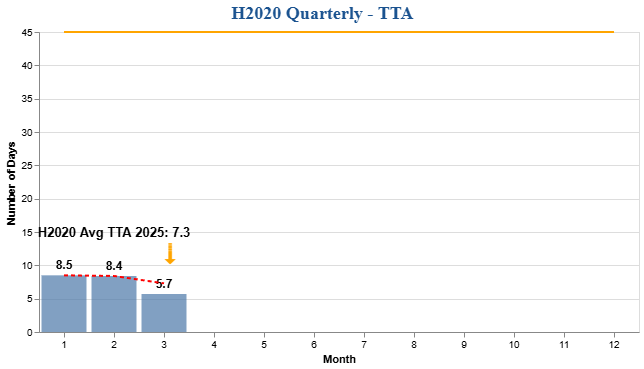

In [12]:
import os
import altair_saver


prog = 'H2020'
save_dir = "charts_out"
os.makedirs(save_dir, exist_ok=True)
out_path = os.path.join(save_dir, f"{prog}_tta_chart.png")

altair_saver.save(chart_TTA_H2020, out_path, method="selenium",   webdriver="chrome" )
